In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
import pysam 
import numpy as np
from Bio import SeqIO
import time 
import matplotlib.patches as patches
import matplotlib.cm as cm
import itertools
from tabulate import tabulate
import csv
import random

np.set_printoptions(threshold=np.inf)
min_quality_score = 8



assembly_ = open("/private/groups/migalab/dan/reference/hg002v1.0.1.fasta", "r")

start_time = time.time()

#Load the reference genome and make it into a dictionary 
fasta_sequences = SeqIO.parse(assembly_, "fasta")
assembly={}
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    assembly[name] = sequence

#Make a dictionary for all the chromosomes and their corresponding sequence length 
assembly_sequence_length = {}    
for chromosome in assembly:
    assembly_sequence_length[chromosome] = len(assembly[chromosome])
    
end_time = time.time()
elapsed_time = end_time - start_time
print (elapsed_time, "seconds")
assembly_.close()



58.867294788360596 seconds


In [2]:
CDR_regions = '/private/groups/migalab/dan/data_analysis/young_old_analysis/HG002_DiMeLo_CENPA_youngpassage.hmmCDR_only_CDR_Dan_certified.bed'
output_dir = Path('/private/groups/migalab/dan/data_analysis/HG002_figure2/b_revised_multi_region')
CENPA_AS_bam_file = '/private/groups/migalab/dan/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1/20240611_1126_1H_PAW33460_814408d8/pod5/06_11_24_R1041_UL_DiMeLo_CENPAyoung_1_5mA_6mC_winnowmap_MD.bam'
CENPC_AS_bam_file = '/private/groups/migalab/dan/01_09_24_R1041_DiMeLoAdaptive_CENPC/01_09_24_R1041_DiMeLoAdaptive_CENPC/01_09_24_R1041_DiMeLoAdaptive_CENPC/20240109_1200_6B_PAS52674_0adbae11/pod5_pass/explicit/01_09_24_R1041_DiMeLoAdaptive_CENPC_5mC_6mA_winnowmap_sorted_MD.bam'
H3K9me3_AS_bam_file = '/private/groups/migalab/dan/08_05_24_R1041_ULadapt_Dimelo_H3K9ME3/08_05_24_R1041_ULadapt_Dimelo_H3K4ME3/08_05_24_R1041_ULadapt_Dimelo_H3K4ME3_1/20240805_1148_1F_PAU87705_0451cc00/pod5/08_05_24_R1041_ULadapt_Dimelo_H3K4ME3_mA_mC_winnowmap_sorted_MD.bam'
ref_genome_file = Path('/private/groups/migalab/dan/reference/hg002v1.0.1.fasta')


In [3]:
''' here in the code, I am formulating the CDR regions and listing the CDRs in each and every chromosome'''
input_file = '/private/groups/migalab/dan/data_analysis/young_old_analysis/HG002_DiMeLo_CENPA_youngpassage.hmmCDR_only_CDR_Dan_certified.bed'
CDR_dict = {}
with open(input_file, 'r') as infile:  
    for i in infile:
        chr_num = i.split('\t')[0]
        CDR_start = i.split('\t')[1]
        CDR_end = i.split('\t')[2].split('\n')[0]
        if chr_num not in CDR_dict:
            CDR_dict[chr_num] = [[CDR_start ,CDR_end]]
        elif chr_num in CDR_dict:  
            CDR_dict[chr_num].append ([CDR_start ,CDR_end])





In [4]:
# Open the BAM file
CENPA_bamfile = pysam.AlignmentFile(CENPA_AS_bam_file, "rb")
CENPC_bamfile = pysam.AlignmentFile(CENPC_AS_bam_file, "rb")
H3K9_bamfile = pysam.AlignmentFile(H3K9me3_AS_bam_file, "rb")

In [5]:


def read_spans_regions(read, regions, thres):
    start_list = []
    span_count = 0
    for region in regions:
        start = int(region[0]) 
        end = int(region[1]) 
        mid_point = (end + start) / 2 
        if read.reference_start > start or read.reference_end < end:
            pass 
        else:
        
            # Calculate coverage range based on the threshold
            coverage_range = (end - start) * (thres / 100) / 2 
            threshold_start = mid_point - coverage_range
            threshold_end = mid_point + coverage_range
            
            # Check if the read spans the threshold region
            if read.reference_start <= threshold_start and read.reference_end >= threshold_end:
                span_count += 1
                start_list.append(start)

    return span_count, start_list


def get_spanning_reads(bamfile, CDR_dict):
    """
    Identifies reads that span multiple regions in the given CDR_dict from a BAM file.

    Parameters:
        bamfile (pysam.AlignmentFile): The BAM file to fetch reads from.
        CDR_dict (dict): A dictionary containing regions for each chromosome.

    Returns:
        dict: A dictionary containing read names as keys and start positions as values
              for reads that span at least two regions.
    """
    # Bins to store read names
    spanning_reads = {}

    # Iterate over chromosomes in the dictionary
    for chromosome, regions in CDR_dict.items():
        for read in bamfile.fetch(chromosome):
            if read.query_length > 50000:
                span_count, start_list = read_spans_regions(read, regions, 100)
                if span_count >= 2:
                    spanning_reads[read.query_name] = start_list

    return spanning_reads



CENPA_spanning_reads = get_spanning_reads(CENPA_bamfile, CDR_dict)




In [6]:
H3K9_spanning_reads = get_spanning_reads(H3K9_bamfile, CDR_dict)
CENPC_spanning_reads = get_spanning_reads(CENPC_bamfile, CDR_dict)

In [7]:
'''
The idea of this function is to isolate the the desired regions (here in the function, it is called the subset) in the mod 
numpy array without dashes(insertions)'''

def mod_subset_producing_step (mod_no_dash,alignment_dash,target_start_no_dash,target_end_no_dash):
    #mod_no_dash = is the numpy array of the mod without any insertions and deletions
    # alignment_dash = is the alignment sequence with the dashes in it 
    # target_start = it's the subset starting position WITHOUT the dashes!!! 


    # Create a mask to identify non-dash positions
    mask = [char != '-' for char in alignment_dash]

    # Generate cumulative counts only for True values in the mask
    cumulative_counts = list(itertools.accumulate(mask))


    
    # Create the final indexes list
    indexes = [count - 1 if is_non_dash else '-' for count, is_non_dash in zip(cumulative_counts, mask)]



    target_start_dash = indexes.index (target_start_no_dash)

        
    try:
        target_end_dash = indexes.index (target_end_no_dash)
    except ValueError: 
        target_end_dash = indexes[-1]




    #obtain dashed alignment 
    alignment_dash_sequence_pre_subset = alignment_dash[0:target_start_dash]
    alignment_dash_sequence_subset = alignment_dash[target_start_dash:target_end_dash]

    #create no dash alignment 
    alignment_no_dash_sequence_pre_subset = alignment_dash_sequence_pre_subset.replace("-","")
    alignment_no_dash_sequence_subset = alignment_dash_sequence_subset.replace("-","")

    subset_no_dash_start = len(alignment_no_dash_sequence_pre_subset)
    subset_no_dash_end = subset_no_dash_start + len(alignment_no_dash_sequence_subset)

    #make mod_no_dash alignment
    mod_subset = mod_no_dash[subset_no_dash_start:subset_no_dash_end]

    return mod_subset





In [38]:
''' 
The input of the function is a dictionary in the format of 'chromosome':[[start,end],[start,end]] 
'''
def region_read_mA_density_calculator (chromosome_coordinates,threshold,mod_tag,filtering_val,mC_threshold_dict, bamfile,spanning_reads,percentage): 
    read_region_check = {}
    read_CDR_region_distribution = {}


    #get each chromosome
    for chr_name in chromosome_coordinates:

        for region in chromosome_coordinates[chr_name]:
            region_base = 0 

            region_start_index = int(region[0])
            region_end_index = int(region[1])

            
            for read in bamfile.fetch(chr_name,region_start_index,region_end_index):
                chromosome = bamfile.get_reference_name(read.reference_id)
                read_name = read.query_name 
                read_start_position = read.reference_start
                read_end_position = read.reference_end
                
                
                    
                if (read_name in spanning_reads)  and (region_start_index in spanning_reads[read_name]):
                    
                    
                    #make an if statement to check a specific read front, middle, end regions 
                    #setting read start, end, density, length variables 
                        

                    #Get the starting and ending positions of the reads 
                    
                    read_density = 0 

                
                    #Get sequence information which shows deletions and insertions 
                    sequence = read.get_aligned_pairs(matches_only=False, with_seq = True)


                    #make |a numpy of the sequence length which eliminates the deletion
                    read_sequence_insertion_included = ''
                    genomic_alignment_sequence_deletion_mistach_included = ''
                    
                    for item in sequence:
                        if item[0] is None:
                            read_sequence_insertion_included+='-'
                        elif item[1] is None:
                            genomic_alignment_sequence_deletion_mistach_included += '-'
                        else: 
                            read_sequence_insertion_included+=item[2]
                            genomic_alignment_sequence_deletion_mistach_included +=item[2]

                    
                    #take sequence length excluding insertions 
                    read_sequence_insertion_included = read_sequence_insertion_included.upper()
                    genomic_alignment_sequence_deletion_mistach_included = genomic_alignment_sequence_deletion_mistach_included.upper()
                    
                    genomic_alignment_sequence_deletion_mistach_included_mask = np.array(
                    [char != '-' for char in genomic_alignment_sequence_deletion_mistach_included])

                    insertions = read_sequence_insertion_included.count ("-")
                    no_insertion_no_deletion_sequence_length = len(read_sequence_insertion_included)

                    #make a mod np array with the length of the read length
                    mod=read.modified_bases_forward
                    
                    #make a mod score with its original length 
                    mod_score = np.zeros(len(genomic_alignment_sequence_deletion_mistach_included),)
                    try:
                        if mod_tag == 'A':
                            for indices, values in mod[('A', 0, 'a')]:
                                mod_score[indices] = values
                            mod_score = mod_score[genomic_alignment_sequence_deletion_mistach_included_mask]
                            

                        elif mod_tag == 'CG':
                            for indices, values in mod[('C', 0, 'm')]:
                                mod_score[indices] = values
                            mod_score = mod_score[genomic_alignment_sequence_deletion_mistach_included_mask]
                            #print ("mod_score:",mod_score)
                        
                        if read.is_reverse:
                                mod_score = mod_score[::-1]


                    # No mod would return KeyError 
                    except KeyError:
                        continue
                    

                    mod_score = np.where(mod_score < filtering_val, 0, mod_score)

                    




                    # if the regions are longer than the reads 
                    if (region_end_index - region_start_index) > (read_end_position - read_start_position):
                        # if the reads are inside the region
                        if (region_end_index >= read_end_position) and (region_start_index <= read_start_position): 
                            mod_start = 0
                            mod_end = len(read_sequence_insertion_included)
                        
                        # if the reads cover the later part of the region
                        elif (region_end_index < read_end_position) and (region_start_index > read_start_position): 
                            mod_start = 0
                            mod_end = no_insertion_no_deletion_sequence_length - read_end_position - region_end_index

                        # if the reads cover the starting part of the region 
                        elif (region_end_index > read_end_position) and (region_start_index > read_start_position): 
                            mod_start = region_start_index - read_start_position 
                            mod_end = no_insertion_no_deletion_sequence_length

                            
                    
                    # if the reads are longer than the region selected 
                    elif (region_end_index - region_start_index) <= (read_end_position - read_start_position):
                        # scenario 1: when the defined region is inside the read
                        if (read_start_position <= region_start_index) and (read_end_position >= region_end_index):
                            mod_start = region_start_index - read_start_position 
                            mod_end = region_end_index - read_start_position

                        # scenario 3: when the defined region covers a bit of the end of the read
                        elif (read_end_position < region_end_index) and (read_end_position > region_start_index):
                            mod_start = region_start_index - read_start_position
                            mod_end = no_insertion_no_deletion_sequence_length

                        # scenario 2: when the defined region covers a bit of the beginning of the read
                        elif (read_start_position > region_start_index) and (read_start_position < region_end_index):
                            mod_start = 0
                            mod_end = region_end_index - read_start_position 

                    
                    #use the defined starting and ending positons in the region to subset mod numpy
                    if (region_start_index - read_start_position) > (no_insertion_no_deletion_sequence_length - insertions):
                        continue
                    try:
                        trimmed_mod_score = mod_subset_producing_step (mod_score,read_sequence_insertion_included,mod_start,mod_end)
                    except ValueError:
                        continue
                    
                
                    region_base += (mod_end - mod_start)
                    #removing all the zeros 
                    mod_no_zeros = trimmed_mod_score[trimmed_mod_score != 0]
                    m_mod_tag = len (mod_no_zeros)
                    
                    
                    #Getting the total amount of As in the subsetted region of the sequence 
                    total_mod_tag = read_sequence_insertion_included[mod_start:mod_end].count(mod_tag)
                
                    #calculate read density
                    try:
                        read_density = m_mod_tag / total_mod_tag
                        if read_name in read_CDR_region_distribution:
                            read_CDR_region_distribution[read_name].append ([m_mod_tag,total_mod_tag,region_start_index])
                        else: 
                            read_CDR_region_distribution[read_name] = [[m_mod_tag,total_mod_tag,region_start_index]]
                        
                    except ZeroDivisionError:
                        pass


                    

                    if mod_tag == "A":

                        if read_density >= threshold:
                            read_CDR_location_density = {}
                            read_CDR_location_density[region_start_index] = read_density
                            if read_name+"*"+chromosome in read_region_check: 
                                read_region_check[read_name+"*"+chromosome].append (read_CDR_location_density)
                            else: 
                                read_region_check[read_name+"*"+chromosome]= [read_CDR_location_density]
                        else: 
                            read_CDR_location_density = {}
                            read_CDR_location_density[region_start_index] = 0
                            if read_name+"*"+chromosome in read_region_check: 
                                read_region_check[read_name+"*"+chromosome].append (False)
                            else: 
                                read_region_check[read_name+"*"+chromosome]= [False]
                        
                        
                    elif mod_tag == "CG":
                        if read_density <= mC_threshold_dict[chromosome]:
                            read_CDR_location_density = {}
                            read_CDR_location_density[region_start_index] = read_density
                            if read_name+"*"+chromosome in read_region_check: 
                                read_region_check[read_name+"*"+chromosome].append (read_CDR_location_density)
                            else: 
                                read_region_check[read_name+"*"+chromosome]= [read_CDR_location_density]
                        else: 
                            read_CDR_location_density = {}
                            read_CDR_location_density[region_start_index] = read_density
                            if read_name+"*"+chromosome in read_region_check: 
                                read_region_check[read_name+"*"+chromosome].append (False)
                            else: 
                                read_region_check[read_name+"*"+chromosome]= [False]

    return  read_region_check, read_CDR_region_distribution

                                



  

                
            #calculate averaged region density average 


    

In [10]:
mC_threshold_chrom_CENPA = {'chr10_MATERNAL': 0.5198893572181243, 'chr10_PATERNAL': 0.48617424242424245, 'chr11_MATERNAL': 0.4, 'chr11_PATERNAL': 0.360015368852459, 'chr12_MATERNAL': 0.5230987917555081, 'chr12_PATERNAL': 0.5260557053009883, 'chr13_MATERNAL': 0.5262725779967159, 'chr13_PATERNAL': 0.35294117647058826, 'chr14_MATERNAL': 0.40661327822268145, 'chr14_PATERNAL': 0.39871794871794874, 'chr15_MATERNAL': 0.387363184079602, 'chr15_PATERNAL': 0.3415895061728395, 'chr16_MATERNAL': 0.36, 'chr16_PATERNAL': 0.37894736842105264, 'chr17_MATERNAL': 0.37733607855559076, 'chr17_PATERNAL': 0.37037037037037035, 'chr18_MATERNAL': 0.4209883010302078, 'chr18_PATERNAL': 0.4762787249814677, 'chr19_MATERNAL': 0.446360153256705, 'chr19_PATERNAL': 0.3962025316455696, 'chr1_MATERNAL': 0.37797619047619047, 'chr1_PATERNAL': 0.3966916354556804, 'chr20_MATERNAL': 0.4228060671722643, 'chr20_PATERNAL': 0.39863013698630134, 'chr21_MATERNAL': 0.43961352657004826, 'chr21_PATERNAL': 0.39879518072289155, 'chr22_MATERNAL': 0.3557372859698441, 'chr22_PATERNAL': 0.4549731182795699, 'chr2_MATERNAL': 0.4134182908545727, 'chr2_PATERNAL': 0.4745762711864407, 'chr3_MATERNAL': 0.4368251410153102, 'chr3_PATERNAL': 0.4392982456140351, 'chr4_MATERNAL': 0.34924242424242424, 'chr4_PATERNAL': 0.43194444444444446, 'chr5_MATERNAL': 0.3576388888888889, 'chr5_PATERNAL': 0.40301003344481606, 'chr6_MATERNAL': 0.42661448140900193, 'chr6_PATERNAL': 0.38416815742397137, 'chr7_MATERNAL': 0.35578661844484627, 'chr7_PATERNAL': 0.38887195121951224, 'chr8_MATERNAL': 0.32756342494714585, 'chr8_PATERNAL': 0.32946931117662825, 'chr9_MATERNAL': 0.4743421052631579, 'chr9_PATERNAL': 0.40900735294117646, 'chrX_MATERNAL': 0.4387755102040816}
mC_threshold_chrom_H3K9 = {'chr10_MATERNAL': 0.46156103286384975, 'chr10_PATERNAL': 0.49230769230769234, 'chr11_MATERNAL': 0.3902439024390244, 'chr11_PATERNAL': 0.38379705400982, 'chr12_MATERNAL': 0.596875, 'chr12_PATERNAL': 0.5511512297226583, 'chr13_MATERNAL': 0.46534891165172854, 'chr13_PATERNAL': 0.3076923076923077, 'chr14_MATERNAL': 0.4275210084033613, 'chr14_PATERNAL': 0.40890090976149496, 'chr15_MATERNAL': 0.33072916666666663, 'chr15_PATERNAL': 0.302692384970866, 'chr16_MATERNAL': 0.3894444444444445, 'chr16_PATERNAL': 0.3852130325814536, 'chr17_MATERNAL': 0.42109929078014185, 'chr17_PATERNAL': 0.4, 'chr18_MATERNAL': 0.5252525252525253, 'chr18_PATERNAL': 0.46027742749054223, 'chr19_MATERNAL': 0.3772038354469533, 'chr19_PATERNAL': 0.36651583710407243, 'chr1_MATERNAL': 0.3756720430107527, 'chr1_PATERNAL': 0.4039205344585092, 'chr20_MATERNAL': 0.5087719298245614, 'chr20_PATERNAL': 0.5283422459893048, 'chr21_MATERNAL': 0.42430441898527005, 'chr21_PATERNAL': 0.33783783783783783, 'chr22_MATERNAL': 0.4059343434343434, 'chr22_PATERNAL': 0.5447860962566844, 'chr2_MATERNAL': 0.4354166666666667, 'chr2_PATERNAL': 0.4444444444444444, 'chr3_MATERNAL': 0.4925373134328358, 'chr3_PATERNAL': 0.5238095238095238, 'chr4_MATERNAL': 0.424812030075188, 'chr4_PATERNAL': 0.42052631578947364, 'chr5_MATERNAL': 0.410958904109589, 'chr5_PATERNAL': 0.4437412095639943, 'chr6_MATERNAL': 0.4845238095238095, 'chr6_PATERNAL': 0.45428826682549134, 'chr7_MATERNAL': 0.3949152542372881, 'chr7_PATERNAL': 0.4274004683840749, 'chr8_MATERNAL': 0.3333333333333333, 'chr8_PATERNAL': 0.37119815668202766, 'chr9_MATERNAL': 0.40667311411992263, 'chr9_PATERNAL': 0.4530791788856305, 'chrX_MATERNAL': 0.44764254385964913}
mC_threshold_chrom_CENPC = {'chr10_MATERNAL': 0.4921875, 'chr10_PATERNAL': 0.4918032786885246, 'chr11_MATERNAL': 0.4131994261119082, 'chr11_PATERNAL': 0.38, 'chr12_MATERNAL': 0.47619047619047616, 'chr12_PATERNAL': 0.5528890959925443, 'chr13_MATERNAL': 0.47761194029850745, 'chr13_PATERNAL': 0.4519969278033794, 'chr14_MATERNAL': 0.447851966873706, 'chr14_PATERNAL': 0.445078031212485, 'chr15_MATERNAL': 0.39680527383367137, 'chr15_PATERNAL': 0.38333333333333336, 'chr16_MATERNAL': 0.379375, 'chr16_PATERNAL': 0.3956521739130435, 'chr17_MATERNAL': 0.4493567822830158, 'chr17_PATERNAL': 0.375, 'chr18_MATERNAL': 0.41818181818181815, 'chr18_PATERNAL': 0.39827586206896554, 'chr19_MATERNAL': 0.45009955201592833, 'chr19_PATERNAL': 0.4592379264510412, 'chr1_MATERNAL': 0.3941076807228916, 'chr1_PATERNAL': 0.42555331991951706, 'chr20_MATERNAL': 0.4705128205128205, 'chr20_PATERNAL': 0.4435336976320583, 'chr21_MATERNAL': 0.4936698844753917, 'chr21_PATERNAL': 0.4032258064516129, 'chr22_MATERNAL': 0.3843091936312275, 'chr22_PATERNAL': 0.41602564102564105, 'chr2_MATERNAL': 0.4888888888888889, 'chr2_PATERNAL': 0.4672043010752688, 'chr3_MATERNAL': 0.484375, 'chr3_PATERNAL': 0.4519969278033794, 'chr4_MATERNAL': 0.43529099123040127, 'chr4_PATERNAL': 0.41818181818181815, 'chr5_MATERNAL': 0.40727124183006536, 'chr5_PATERNAL': 0.3875, 'chr6_MATERNAL': 0.5245310245310246, 'chr6_PATERNAL': 0.4163265306122449, 'chr7_MATERNAL': 0.4076704545454546, 'chr7_PATERNAL': 0.44868667917448407, 'chr8_MATERNAL': 0.31343283582089554, 'chr8_PATERNAL': 0.3793103448275862, 'chr9_MATERNAL': 0.48030303030303034, 'chr9_PATERNAL': 0.4390889830508474, 'chrX_MATERNAL': 0.4467721632799856}


In [39]:

CENPA_reads_spanning_dict_mA, CENPA_reads_CDR_mA_distribution_dict_mA = region_read_mA_density_calculator (CDR_dict,0.010980930464155464,"A",230, mC_threshold_chrom_CENPA, CENPA_bamfile,CENPA_spanning_reads,1)

KeyboardInterrupt: 

In [132]:
CENPC_reads_spanning_dict_mA, CENPC_reads_CDR_mA_distribution_dict_mA = region_read_mA_density_calculator (CDR_dict,0.013633102908569193,"A",230, mC_threshold_chrom_CENPC, CENPC_bamfile,CENPC_spanning_reads)

In [131]:
CENPC_reads_spanning_dict_mC, CENPC_reads_CDR_mA_distribution_dict_mC = region_read_mA_density_calculator (CDR_dict,0.013633102908569193,"CG",230, mC_threshold_chrom_CENPC, CENPC_bamfile,CENPC_spanning_reads)

In [12]:
CENPA_reads_spanning_dict_mC, CENPA_reads_CDR_mA_distribution_dict_mC = region_read_mA_density_calculator (CDR_dict,0.010980930464155464,"CG",210, mC_threshold_chrom_CENPA, CENPA_bamfile,CENPA_spanning_reads)


In [74]:
H3K9_reads_spanning_dict_mA, H3K9_reads_CDR_mA_distribution_dict_mA = region_read_mA_density_calculator (CDR_dict,0.02034009519996441,"H3",230, mC_threshold_chrom_CENPA, H3K9_bamfile,H3K9_spanning_reads)

KeyboardInterrupt: 

In [10]:
H3K9_reads_spanning_dict_mC, H3K9_reads_CDR_mA_distribution_dict_mC = region_read_mA_density_calculator (CDR_dict,0.02034009519996441,"CG",210, mC_threshold_chrom_H3K9, H3K9_bamfile,H3K9_spanning_reads)

In [13]:
import pandas as pd

def primary_dict_to_dataframe(primary_dict_1, primary_dict_2, char):
    # Lists to store data for each column
    read_names = []
    total_aggregate_sub_CDR_spanned = []
    sub_CDR_in_read = []
    chromosome_name = []
    number_C = []
    number_mC = []
    indi_sub_CDR = []

    for primary_key, sec_dicts in primary_dict_1.items():
        read_names.append(primary_key.split("*")[0])
        chromosome_name.append(primary_key.split("*")[1])

        # Number of secondary dictionaries
        num_sec_dicts = len(sec_dicts)
        total_aggregate_sub_CDR_spanned.append(num_sec_dicts)

        # Count values that are False in all secondary dictionaries
        non_zero_count = 0
        for sec_dict in sec_dicts:
            # Ensure sec_dict is a dictionary before accessing values
            if isinstance(sec_dict, dict):
                for value in sec_dict.values():
                    if value:  # Check if the value is not False
                        non_zero_count += 1  # Increment the counter

        sub_CDR_in_read.append(non_zero_count)

    for primary_key, sec_dicts in primary_dict_2.items():
        read_name = primary_key.split("*")[0]

        indi_sub = []
        for sublist in primary_dict_2[read_name]:
            indi_sub.append(sublist[0] / sublist[1])

        indi_sub_CDR.append(indi_sub)
        number_C.append(sum(sublist[1] for sublist in primary_dict_2[read_name]))
        number_mC.append(sum(sublist[0] for sublist in primary_dict_2[read_name]))
    
    print (len(read_names),len(chromosome_name),len(total_aggregate_sub_CDR_spanned),len(sub_CDR_in_read),len(indi_sub_CDR),len(number_C),len(number_mC))

    # Create a DataFrame
    df = pd.DataFrame({
        'read names': read_names,
        'chromosome': chromosome_name,
        '# of total aggregate sub CDR spanned': total_aggregate_sub_CDR_spanned,
        '# of sub CDR in read': sub_CDR_in_read,
        'density per sub CDR': indi_sub_CDR,
        '# of total ' + char: number_C,
        '# of total m' + char: number_mC
    })

    # Add a new column calculating the proportion of sub CDR in read
    df['Proportion_sub_CDR(%)'] = (df['# of sub CDR in read'] / df['# of total aggregate sub CDR spanned']) * 100

    return df


In [139]:
print (len(CENPC_reads_spanning_dict_mC),len(CENPC_reads_spanning_dict_mC))

1390 1390


In [14]:


df_mC = primary_dict_to_dataframe(CENPA_reads_spanning_dict_mC,CENPA_reads_CDR_mA_distribution_dict_mC,'CG')
df_mC['read overall mCpG density'] = df_mC['# of total mCG'] / df_mC['# of total CG']
df_mA = primary_dict_to_dataframe(CENPA_reads_spanning_dict_mA,CENPA_reads_CDR_mA_distribution_dict_mA,'A')
df_mA['read overall mA density'] = df_mA['# of total mA'] / df_mA['# of total A']




1896 1896 1896 1896 1896 1896 1896
1896 1896 1896 1896 1896 1896 1896


In [15]:

def remove_reads_with_zero_proportion(df_mC, df_mA):
    """
    Removes rows from df_mA where the corresponding read in df_mC has a value of 0
    in the 'Proportion_sub_CDR(%)' column.
    
    Args:
        df_mC (pd.DataFrame): DataFrame with mCpG data.
        df_mA (pd.DataFrame): DataFrame with mA data.

    Returns:
        pd.DataFrame: Filtered df_mA with the specified reads removed.
    """
    # Identify the reads in df_mC where 'Proportion_sub_CDR(%)' is 0
    reads_to_remove = df_mC[df_mC['Proportion_sub_CDR(%)'] != 100]['read names']

    # Filter out these reads from df_mA
    filtered_df_mA = df_mA[~df_mA['read names'].isin(reads_to_remove)]

    return filtered_df_mA

CENPA_filtered_df_mA = remove_reads_with_zero_proportion(df_mC, df_mA)

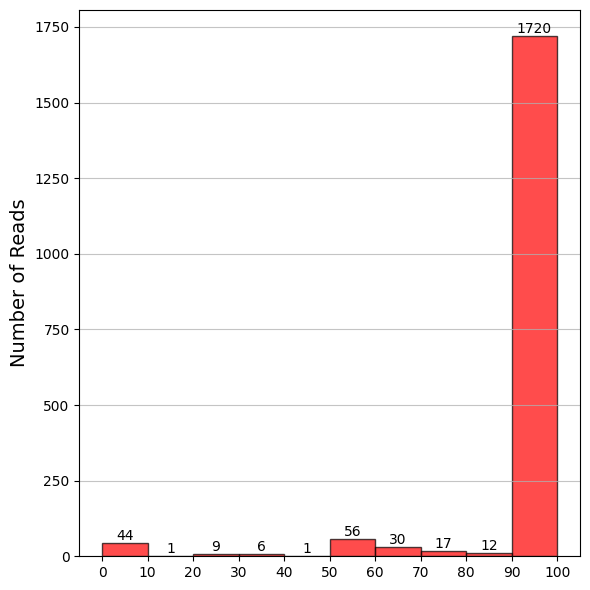

In [16]:

# Step 2: Define the bins for the histogram (0-10%, 10-20%, ..., 90-100%)
bins = range(0, 110, 10)  # This creates bins: [0-10), [10-20), ..., [90-100]

# Step 3: Plot the histogram
plt.figure(figsize=(6, 6))
n, bins, patches = plt.hist(
    df_mC['Proportion_sub_CDR(%)'],
    bins=bins,
    edgecolor='black',
    alpha=0.7,
    color='red'
)

# Step 4: Customize the plot
#plt.xlabel('Proportion of sub CDR where mCpG < top 10% percentile of chromosome methylation', fontsize=14)
plt.ylabel('Number of Reads', fontsize=14)
#plt.title('Histogram of single read sub CDR methylation < top 10% percentile of chromosome methylation', fontsize=16)
plt.xticks(bins)  # Set x-axis ticks to align with bins
plt.grid(axis='y', alpha=0.75)

# Optional: Add percentage labels above each bar
for count, bin_edge in zip(n, bins):
    plt.text(
        bin_edge + 5,       # Position text in the middle of the bin
        count,               # Y-coordinate (height of the bar)
        f'{int(count)}',     # Text to display
        ha='center',
        va='bottom',
        fontsize=10
    )

# Step 5: Display the plot

plt.tight_layout()

plt.show()


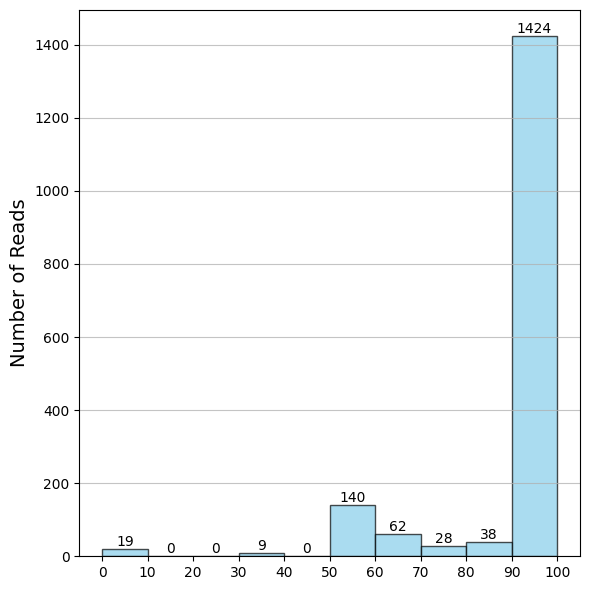

In [17]:




# Step 2: Define the bins for the histogram (0-10%, 10-20%, ..., 90-100%)
bins = range(0, 110, 10)  # This creates bins: [0-10), [10-20), ..., [90-100]

# Step 3: Plot the histogram
plt.figure(figsize=(6, 6))
n, bins, patches = plt.hist(
    CENPA_filtered_df_mA['Proportion_sub_CDR(%)'],
    bins=bins,
    edgecolor='black',
    alpha=0.7,
    color='skyblue'
)

# Step 4: Customize the plot
#plt.xlabel('Proportion of CENPA Enrichment Domains per CDR (%)', fontsize=14)
plt.ylabel('Number of Reads', fontsize=14)
#plt.title('Histogram of CENPA Enrichment Proportions per CDR', fontsize=16)
plt.xticks(bins)  # Set x-axis ticks to align with bins
plt.grid(axis='y', alpha=0.75)

# Optional: Add percentage labels above each bar
for count, bin_edge in zip(n, bins):
    plt.text(
        bin_edge + 5,       # Position text in the middle of the bin
        count,               # Y-coordinate (height of the bar)
        f'{int(count)}',     # Text to display
        ha='center',
        va='bottom',
        fontsize=10
    )

# Step 5: Display the plot

plt.tight_layout()

plt.show()


In [26]:
reads_below_100_percent_CENPA = CENPA_filtered_df_mA[CENPA_filtered_df_mA['Proportion_sub_CDR(%)'] < 100]
chromosomes_of_interest = ['chr10_PATERNAL']  
filtered_reads = reads_below_100_percent_CENPA[reads_below_100_percent_CENPA['chromosome'].isin(chromosomes_of_interest)]
#print(filtered_reads)


# Extract the read names from the filtered DataFrame
read_names = filtered_reads['read names'].tolist()

# Retrieve the corresponding entries from the CENPA_spanning_reads dictionary
filtered_read_contents = {read_name: CENPA_spanning_reads[read_name] for read_name in read_names if read_name in CENPA_spanning_reads}

# Print the contents of the filtered reads
for read_name, content in filtered_read_contents.items():
    print(f"Read Name: {read_name}, Content: {content}")


Read Name: 3c0bb4b8-3a19-40c4-bb99-d33d8a8edfa4, Content: [41441384, 41454240, 41462117]
Read Name: a874aa58-406c-48ce-bc5c-199be58ec910, Content: [41441384, 41454240, 41462117]
Read Name: e44fe1ef-cb63-44ed-b215-dff6b2f7a121, Content: [41441384, 41454240, 41462117]
Read Name: 92d8ba05-0c4b-4aa8-878d-d28234e2742c, Content: [41441384, 41454240, 41462117, 41479759]
Read Name: b1cdc6e3-40f3-44a9-85af-6084f9b0a17f, Content: [41441384, 41454240, 41462117, 41479759]
Read Name: 81773739-68ae-495d-9e49-45b2b20114a7, Content: [41441384, 41454240, 41462117]
Read Name: 2de6a43b-aa2d-4a37-a065-fa867685b6af, Content: [41454240, 41462117, 41479759, 41503453, 41562489, 41578169]
Read Name: b17cbdc6-3023-4c7f-b1fa-5399b9ce2f32, Content: [41503453, 41562489, 41578169, 41594115]
Read Name: ee20057f-4718-4999-bf0b-ca68930824e4, Content: [41562489, 41578169, 41594115]
Read Name: fc6e4406-9105-46a6-8542-861ab2230bb2, Content: [41562489, 41578169, 41594115]
Read Name: 91671356-9afe-4b30-b83b-30566c5135e3, C